In [2]:




"""
Created on Mon Apr 16 10:33:22 2018
New basis function
@author: Lukas
"""
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as spl
import scipy.constants as spc
import scipy.integrate as spi
from bspline import Bspline
from bspline.splinelab import aptknt

def Vol(r): 
    return(4/3*np.pi*r**3)
    
def uniform_pot(r,R, Q=1): #see eq. (14) in Assignment PDF
    return(np.piecewise(r,[r<=R, r>R], [lambda x: Q/Vol(R), lambda x: 0])) 
    
def analytic_uniform_shell(r,R,Q=1):
    return(np.piecewise(r,[r<=R,r>R],[lambda x: Q/R*(3/2-x**2/(2*R**2)),lambda x: Q/x]) ) 

def shell_pot(r,R_in,R_out,Q=1): #see eq. (15) in Assignment PDF
    return(np.piecewise(r,[r<R_in,(r>=R_in) & (r<=R_out),r>R_out], [lambda x: 0, lambda x: np.abs(Q/Vol(R_in)-Q/Vol(R_out)),lambda x: 0]))

# Hydrogen wave functions according to Demtröder 3 page 149
def H_psi_n1(r,Z=1,a0 = 1): 
    return(1/np.sqrt(np.pi)* (Z/a0)**(3/2)* np.exp(-Z*r/a0) ) #n=1,l=0, m=0

def H_psi_n2(r, Z = 1,a0=1):
    return(1/(4*np.sqrt(2*np.pi)) * (Z/a0)**(3/2)* (2-Z*r/a0) * np.exp(-Z*r/2*a0)) #n=2,l=0, m=0   
 
R = 1; Delta = 1e-8; Q = 1; gap=0.2; el_charge = 1

        
r = np.linspace(Delta,12,50) #Points where Splines and phi need to collocate
'''
for i in range(len(r)):
  if i == np.max(np.where(r<R)):
      print(i)
      r[i] = R-Delta
  if i == np.min(np.where(r>R)):
      print(i)
      r[i] = R+Delta
'''      
      
knot_vector = aptknt(r, 3) #kreates knot points with Ghost points
basis = Bspline(knot_vector,3) #Object of basic spline vectors: basis(0) gives 0´th basis spline


A1 = basis.collmat(r)  # Full collocation matrix, where points of agreement are knot points r
A2 = basis.collmat(r, deriv_order=2) #2nd order derivative of Bspline matrix

c1 = np.zeros(np.size(A2[0,:])); c1[0] = 1 #Adding boundary conditions
c2 = np.zeros(np.size(A2[0,:])); c2[-1] = 1 #first coefficient is 0 and last one is Q See in pot
A2[0] = c1
A2[-1] = c2

pot = -r * 4*np.pi* uniform_pot(r,R)
pot[0] = 0 #Boundary condition: setting c0 to 0 because phi(r=0)=0
pot[-1] = Q  #if r goes to infty the potential goes to Q phi(r=infty) =Q
 
LUA2 = spl.lu_factor(A2) # Do LU decomposition, so switching to different potentials is faster. 

#Uniformely charged sphere
C = spl.lu_solve(LUA2,pot) #Solve the matrix equation with Bspline''(r)*c_n = roh(r) to get the coefficients
phi = np.dot(A1,C) # to get Potential phi one can use dotprouct. See eq. (11) in Assignment PDF

#Uniformely charged shell
pot_shell = -r*4*np.pi*shell_pot(r,R-gap,R+gap)
pot_shell[0] = 0 
pot_shell[-1] = Q

C_shell = spl.lu_solve(LUA2,pot_shell) 
phi_shell = np.dot(A1,C_shell)

#Checking for Normalization of the used wave functions: integral(4*pi*r**2*psi(r)**2*dr) =1
def H_psi_n1_norm(r,Z=1,a0 = 1): 
    return(4*np.pi*r**2* (1/np.sqrt(np.pi)* (Z/a0)**(3/2)* np.exp(-Z*r/a0))**2 )
def H_psi_n2_norm(r, Z = 1,a0=1):
    return(4*np.pi*r**2* (1/(4*np.sqrt(2*np.pi)) * (Z/a0)**(3/2)* (2-Z*r/a0) * np.exp(-Z*r/2*a0))**2 )    

norm_psi_n1 = spi.quad(H_psi_n1_norm,0,1000)
norm_psi_n2 = spi.quad(H_psi_n2_norm,0,1000)
print('Norm_n1 = '+str(norm_psi_n1[0])+' Error= '+str(norm_psi_n1[1]))
print('Norm_n2 = '+str(norm_psi_n2[0])+' Error= '+str(norm_psi_n2[1]))

#solve for Hydrogen atom
pot_psi_n1 = -r*4*np.pi*el_charge*H_psi_n1(r)**2
pot_psi_n1[0] = 0 
pot_psi_n1[-1] = el_charge
C_psi_n1 = spl.lu_solve(LUA2,pot_psi_n1) 
phi_psi_n1 = np.dot(A1,C_psi_n1)


pot_psi_n2 = -r*4*np.pi*el_charge*H_psi_n2(r)**2
pot_psi_n2[0] = 0 
pot_psi_n2[-1] = el_charge
C_psi_n2 = spl.lu_solve(LUA2,pot_psi_n2) 
phi_psi_n2 = np.dot(A1,C_psi_n2)


Norm_n1 = 0.9999999999999999 Error= 1.0812512262409847e-13
Norm_n2 = 1.0 Error= 5.582255950060929e-11


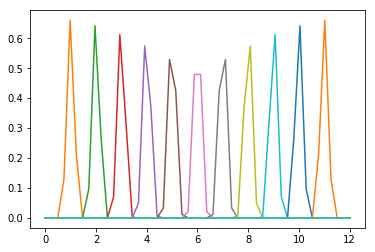

(50, 50)


In [9]:
for i in range(len(r)):
    plt.plot(r,basis(i))
plt.show()


In [11]:
Ainv = spl.inv(A2)